### Training RL Policies using L5Kit Closed-Loop Environment

This notebook describes how to train RL policies for self-driving using our gym-compatible closed-loop environment.

We will be using [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347) algorithm as our reinforcement learning algorithm, as it not only demonstrates remarkable performance but it is also empirically easy to tune.

The PPO implementation in this notebook is based on [Stable Baselines3](https://github.com/DLR-RM/stable-baselines3) framework, a popular framework for training RL policies. Note that our environment is also compatible with [RLlib](https://docs.ray.io/en/latest/rllib.html), another popular frameworks for the same.

ref: 
([rllib] Best workflow to train, save, and test agent #9123
)[https://github.com/ray-project/ray/issues/9123]

In [1]:
import os
os.environ["L5KIT_DATA_FOLDER"] = '/workspace/datasets'
# os.environ["TUNE_RESULT_DIR"] =  '/DATA/l5kit/rllib_tb_logs'

In [2]:
import gym
from l5kit.configs import load_config_data
from l5kit.environment.envs.l5_env import SimulationConfigGym, GymStepOutput, L5Env
from l5kit.visualization.visualizer.zarr_utils import episode_out_to_visualizer_scene_gym_cle
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.environment.gym_metric_set import L2DisplacementYawMetricSet, CLEMetricSet
from prettytable import PrettyTable
import datetime
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
import torch.nn as nn
import numpy as np
import gym
from typing import Dict
import numpy as np
import ray
import pytz
from ray import tune

## Init ray and env

In [3]:
ray.init(num_cpus=12, ignore_reinit_error=True, log_to_driver=False)

2023-03-27 10:29:16,326	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.8.16
Ray version:,2.2.0


In [4]:

from l5kit.configs import load_config_data

# get environment config
# env_config_path = '/workspace/source/configs/gym_config_history3.yaml'
#env_config_path = '/workspace/source/configs/gym_config84.yaml'
env_config_path = '/workspace/source/configs/gym_config.yaml'
# env_config_path = '/workspace/source/src/configs/gym_vectorizer_config.yaml'
cfg = load_config_data(env_config_path)

## Customize my model

In [5]:
from ray.rllib.models import ModelCatalog
from src.customModel.customModel import TorchGNCNN, TorchGNCNN_separated, TorchAttentionModel2,TorchAttentionModel

ModelCatalog.register_custom_model("GN_CNN_torch_model", TorchGNCNN)
ModelCatalog.register_custom_model("GN_CNN_separated_torch_model", TorchGNCNN_separated)
ModelCatalog.register_custom_model( "TorchSeparatedAttentionModel", TorchAttentionModel)
ModelCatalog.register_custom_model( "TorchSharedAttentionModel", TorchAttentionModel2)

## Define Training and Evaluation Environments

**Training**: We will be training the PPO policy on episodes of length 32 time-steps. We will have 4 sub-processes (training environments) that will help to parallelize and speeden up episode rollouts. The *SimConfig* dataclass will define the parameters of the episode rollout: like length of episode rollout, whether to use log-replayed agents or simulated agents etc.

**Evaluation**: We will evaluate the performance of the PPO policy on the *entire* scene (~248 time-steps).

### Calculate # channels

In [6]:
n_channels = (cfg['model_params']['future_num_frames'] + 1)* 2 + 3
print(cfg['model_params']['future_num_frames'], cfg['model_params']['history_num_frames'], n_channels)

1 1 7


In [7]:
from ray import tune
from src.customEnv.wrapper import L5EnvWrapper
train_eps_length = 32
train_sim_cfg = SimulationConfigGym()
train_sim_cfg.num_simulation_steps = train_eps_length + 1


# Register , how your env should be constructed (always with 5, or you can take values from the `config` EnvContext object):
env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': True, 'sim_cfg': train_sim_cfg}

tune.register_env("L5-CLE-V0", lambda config: L5Env(**env_kwargs))
tune.register_env("L5-CLE-V1", lambda config: L5EnvWrapper(env = L5Env(**env_kwargs), \
                                                           raster_size= cfg['raster_params']['raster_size'][0], \
                                                           n_channels = n_channels))

In [9]:
from l5kit.environment.envs.l5_env2 import GymStepOutput, SimulationConfigGym, L5Env2

train_eps_length = 32
train_sim_cfg = SimulationConfigGym()
train_sim_cfg.num_simulation_steps = train_eps_length + 1

env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': False, 'sim_cfg': train_sim_cfg}
tune.register_env("L5-CLE-V2", lambda config: L5Env2(**env_kwargs))

## Train

### ref

Resume stop tune: https://docs.ray.io/en/latest/tune/tutorials/tune-stopping.html

tune.Tuner analysis: https://docs.ray.io/en/latest/rllib/rllib-training.html#basic-python-api

get best result, load from dir: https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html#trial-level-analysis-working-with-an-individual-result

### Hyperparam
```
lr = 3e-4
num_rollout_steps = 256
gamma = 0.8
gae_lambda = 0.9
n_epochs = 10
seed = 42
batch_size = 64
```
### Clipping schedule of PPO epsilon parameter
```
start_val = 0.1
end_val = 0.01
training_progress_ratio = 1.0
clip_schedule = get_linear_fn(start_val, end_val, training_progress_ratio)
```

In [10]:
!wandb login 083592c84134c040dcca598c644c348d32540a08

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
import numpy as np

import ray
from ray import air, tune
from ray.air import session
from ray.air.integrations.wandb import setup_wandb
from ray.air.integrations.wandb import WandbLoggerCallback
os.environ['WANDB_NOTEBOOK_NAME'] = 'rllib_ppo_policy_training.ipynb'
os.environ["WANDB_API_KEY"] = '083592c84134c040dcca598c644c348d32540a08'

In [12]:
import wandb
wandb.init(project="l5kit2", reinit = True)

wandb: Currently logged in as: pronton2001. Use `wandb login --relogin` to force relogin


### debug

In [13]:
import ray
from ray import air, tune

train_envs = 4
hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/workspace/datasets/ray_results/' +'debug_'+ date

config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "tf",
    "num_gpus": 2,
    "num_workers": 2,
    "num_envs_per_worker": train_envs,
    'num_sgd_iter': 1,
    'sgd_minibatch_size': 32,
    # 'num_cpus_per_worker': 0,  # This avoids running out of resources in the notebook environment when this cell is re-executed
    # "model": {
    #     "custom_model": "GN_CNN_torch_model",
    #     "custom_model_config": {'feature_dim':128},
    # },
        'model' : {
            "dim": 84,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
            "vf_share_layers": True,   
    },
    '_disable_preprocessor_api': True,
    "eager_tracing": False,
     "restart_failed_sub_environments": True,
    "lr": 0.0003,
    "gamma": 0.8,
    'seed': 42,
}

result_grid = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(6e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=4, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean')
        ),
    param_space=config_param_space).fit()

2023-03-23 13:17:32,792	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-03-23 13:17:32,793	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.


Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
PPO_L5-CLE-V1_11f51_00000,204000,"{'num_env_steps_sampled': 204000, 'num_env_steps_trained': 204000, 'num_agent_steps_sampled': 204000, 'num_agent_steps_trained': 204000}",{},2023-03-23_13-48-43,False,31,{},-72.2904,-271.537,-424.633,128,6576,b10450a215964734b9f879932f44cec6,815d38126431,"{'learner': {'default_policy': {'learner_stats': {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 0.0003000000142492354, 'total_loss': 9.227027, 'policy_loss': 0.035134558, 'vf_loss': 9.179155, 'vf_explained_var': 0.057346385, 'kl': 0.06368031, 'entropy': 5.241145, 'entropy_coeff': 0.0, 'model': {}}, 'train': None, 'num_grad_updates_lifetime': 6313.0, 'diff_num_grad_updates_vs_sampler_policy': 62.0}}, 'num_env_steps_sampled': 204000, 'num_env_steps_trained': 204000, 'num_agent_steps_sampled': 204000, 'num_agent_steps_trained': 204000}",51,172.17.0.2,204000,204000,204000,4000,204000,4000,0,2,0,0,4000,"{'cpu_util_percent': 48.41698113207548, 'ram_util_percent': 70.5075471698113}",3813666,{},{},{},"{'mean_raw_obs_processing_ms': 40.120358420542146, 'mean_inference_ms': 2.1864437298710957, 'mean_action_processing_ms': 0.3665060787770118, 'mean_env_wait_ms': 26.04979443309832, 'mean_env_render_ms': 0.0}","{'episode_reward_max': -72.29036466497928, 'episode_reward_min': -424.6326723098755, 'episode_reward_mean': -271.5368013003099, 'episode_len_mean': 31.0, 'episode_media': {}, 'episodes_this_iter': 128, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-320.49872756004333, -331.33009111881256, -254.64759904146194, -258.95016618818045, -73.37109054625034, -353.94468382000923, -407.4657236933708, -178.12901408970356, -131.25328987836838, -153.18648019433022, -319.9833137989044, -227.77784448862076, -341.04319709539413, -323.95929288864136, -401.3403364419937, -394.8538956642151, -309.15074026584625, -401.98069047927856, -222.00590401887894, -364.9382453262806, -126.42855529487133, -233.3707655519247, -386.8329568505287, -230.68263341486454, -133.8042548596859, -394.9319787621498, -381.70598965883255, -216.73011784255505, -327.7143855392933, -350.1724712252617, -406.6787306070328, -323.8115485459566, -359.47855192422867, -160.0938250720501, -148.0114896185696, -408.42030838131905, -131.09166803956032, -187.0251097343862, -175.76716822385788, -330.62593407928944, -337.9513493180275, -361.497356235981, -115.77321666479111, -121.0280089378357, -306.89625126868486, -207.52321684360504, -334.917503207922, -346.4921433031559, -364.7035163640976, -182.67496529221535, -370.375956594944, -115.55557650327682, -302.8898401260376, -191.20162600278854, -72.29036466497928, -261.7524892091751, -329.5795161873102, -190.30997759103775, -367.97856444120407, -107.87456357479095, -110.7568706870079, -146.62701296806335, -361.8665780425072, -194.91470009088516, -378.94415056705475, -237.8127675652504, -117.96578252315521, -163.33206252753735, -300.3116058707237, -108.44765305519104, -377.5449169874191, -83.05031706392765, -378.5364275574684, -293.82226648926735, -412.0138610005379, -163.14295241236687, -281.5633153319359, -371.666650891304, -380.92470440268517, -399.0747767686844, -327.5645308494568, -87.48160510137677, -306.32372057437897,

2023-03-23 13:49:12,445	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-03-23 13:49:13,662	ERROR tune.py:758 -- Trials did not complete: [PPO_L5-CLE-V1_11f51_00000]
2023-03-23 13:49:13,663	INFO tune.py:762 -- Total run time: 1900.92 seconds (1900.66 seconds for the tuning loop).
2023-03-23 13:49:13,664	WARNING tune.py:768 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


### Shared Policy

In [ ]:
import ray
from ray import air, tune
hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/workspace/datasets/ray_results/' + date

train_envs = 4
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
lr_time = int(4e6)

config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "tf",
    "num_gpus": 1,
    "num_workers": 2,
    "num_envs_per_worker": train_envs,
    # "model": {
    #     "custom_model": "GN_CNN_torch_model",
    #     "custom_model_config": {'feature_dim':128},
    # },
    
    'model' : {
            # "dim": 84,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            # "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
            "vf_share_layers": False,   
    },
    
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
    "lr": lr,
    'seed': 42,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    'train_batch_size': 8000,
    'sgd_minibatch_size': 1024,
    'num_sgd_iter': 16,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    # "rollout_fragment_length": 32,
    'gamma': 0.8,    
}

result_grid = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(6e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=4, 
                                               checkpoint_frequency = 10, 
                                               checkpoint_score_attribute = 'episode_reward_mean'),
        callbacks=[WandbLoggerCallback(project="l5kit2", save_checkpoints=True),],
        ),
    param_space=config_param_space).fit()
    

2023-03-23 13:49:34,267	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-03-23 13:49:34,268	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find rllib_ppo_policy_training.ipynb.


wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.


Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
PPO_L5-CLE-V1_8b412_00000,496000,"{'num_env_steps_sampled': 496000, 'num_env_steps_trained': 496000, 'num_agent_steps_sampled': 496000, 'num_agent_steps_trained': 496000}",{},2023-03-23_15-12-47,False,31,{},-3.67105,-113.122,-409.466,264,16000,817974e880aa423583cd3460524fc69e,815d38126431,"{'learner': {'default_policy': {'learner_stats': {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 2.9999999242136255e-05, 'total_loss': 6.7157183, 'policy_loss': -0.013384043, 'vf_loss': 6.720734, 'vf_explained_var': 0.21319821, 'kl': 0.04184149, 'entropy': 3.50981, 'entropy_coeff': 0.0, 'model': {}}, 'train': None, 'num_grad_updates_lifetime': 6888.5, 'diff_num_grad_updates_vs_sampler_policy': 55.5}}, 'num_env_steps_sampled': 496000, 'num_env_steps_trained': 496000, 'num_agent_steps_sampled': 496000, 'num_agent_steps_trained': 496000}",62,172.17.0.2,496000,496000,496000,8000,496000,8000,0,2,0,0,8000,"{'cpu_util_percent': 46.99699248120301, 'ram_util_percent': 72.70827067669174}",4149783,{},{},{},"{'mean_raw_obs_processing_ms': 46.68958204869014, 'mean_inference_ms': 2.631872933237124, 'mean_action_processing_ms': 0.3837905613288319, 'mean_env_wait_ms': 26.319004557186204, 'mean_env_render_ms': 0.0}",4964.08,92.8366,4964.08,"{'training_iteration_time_ms': 90413.366, 'load_time_ms': 205.979, 'load_throughput': 38838.823, 'learn_time_ms': 2171.2, 'learn_throughput': 3684.598, 'synch_weights_time_ms': 5.373}",1679584367,0,496000,62,8b412_00000,23.1768


wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_20-49-34/PPO/PPO_L5-CLE-V1_8b412_00000_0_2023-03-23_13-49-34/checkpoint_000010)... Done. 0.1s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_20-49-34/PPO/PPO_L5-CLE-V1_8b412_00000_0_2023-03-23_13-49-34/checkpoint_000020)... Done. 0.1s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_20-49-34/PPO/PPO_L5-CLE-V1_8b412_00000_0_2023-03-23_13-49-34/checkpoint_000030)... Done. 0.1s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_20-49-34/PPO/PPO_L5-CLE-V1_8b412_00000_0_2023-03-23_13-49-34/checkpoint_000040)... Done. 0.1s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_20-49-34/PPO/PPO_L5-CLE-V1_8b412_00000_0_2023-03-23_13-49-34/checkpoint_000050)... Done. 0.1s
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Adding directory to artifact (/workspace/datasets/ray_results/2

In [ ]:
import ray
from ray import air, tune
hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/workspace/datasets/ray_results/' + date

train_envs = 4
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
lr_time = int(4e6)

config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 3,
    "num_envs_per_worker": train_envs,
    "model": {
        "custom_model": "GN_CNN_torch_model",
        "custom_model_config": {'feature_dim':128},
    },
    
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
    "lr": lr,
    'seed': 42,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    'train_batch_size': 8000,
    'sgd_minibatch_size': 1024,
    'num_sgd_iter': 16,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 32,
    'gamma': 0.8,    
}

result_grid = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(6e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=4, 
                                               checkpoint_frequency = 10, 
                                               checkpoint_score_attribute = 'episode_reward_mean'),
        callbacks=[WandbLoggerCallback(project="l5kit2", save_checkpoints=True),],
        ),
    param_space=config_param_space).fit()
    

### Restore a specific checkpoint

In [ ]:
# config_param_space['lr'] = 3e-5
path_to_trained_agent_checkpoint = 'datasets/ray_results/23-03-2023_13-36-12/PPO/PPO_L5-CLE-V1_010e0_00000_0_2023-03-23_06-36-12/checkpoint_000380'
from ray.rllib.algorithms.ppo import PPO
ray.tune.run(PPO, config=config_param_space, restore=path_to_trained_agent_checkpoint)

In [ ]:
import ray
from ray import air, tune
ray_result_logdir = '/DATA/l5kit/ray_results'
config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 63,
    'train_batch_size': 4000,
    'sgd_minibatch_size': 4096,
    "num_envs_per_worker": 32,
    'num_sgd_iter': 32,
    'sgd_minibatch_size': 256,
    # 'num_cpus_per_worker': 0,  # This avoids running out of resources in the notebook environment when this cell is re-executed
    "model": {
        "custom_model": "GN_CNN_torch_model",
        "custom_model_config": {'feature_dim':128},
    },
    
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     # "log_level": "DEBUG",
     "restart_failed_sub_environments": True,
    "lr": 0.0003,
    "gamma": 0.8,
    'seed': 42,
}

result_grid = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": -30, 'timesteps_total': int(12e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=4, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean')
        ),
    param_space=config_param_space).fit()

In [ ]:
ray_result_logdir = '/DATA/l5kit/ray_results'

tuner = tune.Tuner.restore(
    path=ray_result_logdir + '/PPO',
)
result_grid = tuner.fit()

In [ ]:
result_grid

# Get the result with the maximum test set `mean_accuracy`
best_result = result_grid.get_best_result()
best_result.checkpoint

In [ ]:
best_result.metrics

In [ ]:
result_df = best_result.metrics_dataframe
result_df[['num_agent_steps_sampled','episode_reward_mean'] ]

In [ ]:
best_result.metrics_dataframe.plot("num_agent_steps_sampled", "episode_reward_mean")


In [ ]:
for result in result_grid:
    print(1)

### Separated policy

In [ ]:
import ray
from ray import air, tune
train_envs = 4
ray_result_logdir = '/DATA/l5kit/ray_results'
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
lr_time = int(4e6)

config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,
    "num_workers": 63,
    "num_envs_per_worker": train_envs,
    '_disable_preprocessor_api': True,
    "eager_tracing": True,
    "restart_failed_sub_environments": True,
    "lr": lr_start,
    # "model": {
    #     "custom_model": "GN_CNN_separated_torch_model",
    #     "custom_model_config": {'feature_dim':128},
    # },
    'model' : {
            "dim": 84,
            # "conv_filters" : [[64, [7,7], 3], [32, [11,11], 3], [32, [11,11], 3]],
            "conv_activation": "relu",
            "post_fcnet_hiddens": [256],
            "post_fcnet_activation": "relu",
            "vf_share_layers": False,   
    },
#
    "lr": lr,
    'seed': 42,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    'train_batch_size': 8000,
    'sgd_minibatch_size': 256,
    'num_sgd_iter': 16,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 32,
    'gamma': 0.8,
}

result_grid = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(6e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=4, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean'),
        callbacks=[WandbLoggerCallback(project="l5kit2", save_checkpoints=True),],
        ),
    param_space=config_param_space).fit()

In [16]:
ray_result_logdir = '/workspace/datasets/ray_results/23-03-2023_13-36-12/'

tuner = tune.Tuner.restore(
    path=ray_result_logdir + 'PPO',
)
tuner.fit()

2023-03-23 07:18:47,187	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-03-23 07:18:47,212	INFO trial_runner.py:688 -- A local experiment checkpoint was found and will be used to restore the previous experiment state.
2023-03-23 07:18:47,213	INFO trial_runner.py:825 -- Using following checkpoint to resume: /workspace/datasets/ray_results/23-03-2023_13-36-12/PPO/experiment_state-2023-03-23_06-36-12.json
2023-03-23 07:18:47,215	WARNING trial_runner.py:830 -- Attempting to resume experiment from /workspace/datasets/ray_results/23-03-2023_13-36-12/PPO. This will ignore any new changes to the specification.
2023-03-23 07:18:47,221	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach 

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find rllib_ppo_policy_training.ipynb.


Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
PPO_L5-CLE-V1_010e0_00000,434000,"{'num_env_steps_sampled': 434000, 'num_env_steps_trained': 434000, 'num_agent_steps_sampled': 434000, 'num_agent_steps_trained': 434000}",{},2023-03-23_07-24-01,False,31,{},-5.4189,-201.399,-416.831,40,13960,04fa847064f84f168bca7e63b950cbe5,815d38126431,"{'learner': {'default_policy': {'learner_stats': {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 2.9999999242136255e-05, 'total_loss': 7.1255136, 'policy_loss': -0.15353686, 'vf_loss': 7.257206, 'vf_explained_var': 0.24996656, 'kl': 0.10921893, 'entropy': 14.321851, 'entropy_coeff': 0.0, 'model': {}}, 'train': None, 'num_grad_updates_lifetime': 2568.5, 'diff_num_grad_updates_vs_sampler_policy': 23.5}}, 'num_env_steps_sampled': 434000, 'num_env_steps_trained': 434000, 'num_agent_steps_sampled': 434000, 'num_agent_steps_trained': 434000}",54,172.17.0.2,434000,434000,434000,1000,434000,1000,0,10,0,0,1000,"{'cpu_util_percent': 84.75, 'ram_util_percent': 71.1875}",3544631,{},{},{},"{'mean_raw_obs_processing_ms': 70.12146488803658, 'mean_inference_ms': 6.949393241840562, 'mean_action_processing_ms': 0.5444782771215971, 'mean_env_wait_ms': 75.51739564761759, 'mean_env_render_ms': 0.0}","{'episode_reward_max': -5.418899339420022, 'episode_reward_min': -416.8307446241379, 'episode_reward_mean': -201.39914259080572, 'episode_len_mean': 31.0, 'episode_media': {}, 'episodes_this_iter': 40, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-415.39010721445084, -18.25421061599627, -6.536419460549951, -306.05977530032396, -155.27015506476164, -21.526762194931507, -42.0768624022603, -327.08898079395294, -344.7285094410181, -213.421240221709, -169.40649657696486, -5.418899339420022, -99.08732810430229, -274.2532938718796, -189.77590061724186, -409.2840898036957, -233.50442264974117, -14.979639370925725, -263.59712675213814, -288.9384271912277, -325.9310363680124, -278.3768076002598, -10.415778825059533, -49.33563754102215, -144.64542428776622, -168.49459706246853, -156.43813633918762, -321.97567719221115, -392.52519059181213, -176.57700118422508, -389.75816236436367, -397.43542248010635, -125.34931713342667, -390.2273618578911, -25.214302556589246, -35.80185077339411, -19.401199638843536, -292.36491322517395, -279.0808511376381, -162.11343270540237, -129.77440406382084, -347.2364945411682, -51.7229455858469, -318.72551652789116, -80.80655665695667, -275.78156822919846, -291.7417603135109, -287.4025077223778, -259.11407139897346, -328.1886873245239, -41.685156954452395, -209.3656961172819, -403.8092547059059, -7.3057731399312615, -239.30862418562174, -15.977616336196661, -179.02108267694712, -284.805492579937, -15.892975606955588, -381.8464401960373, -208.42662751674652, -251.2107334062457, -96.4848848534748, -111.49465590715408, -238.83821193873882, -304.3171819448471, -8.853597876615822, -416.8307446241379, -259.18487960100174, -345.17886888980865, -65.46823631599545, -76.12656515929848, -148.90304525196552, -382.00944823026657, -50.411372765898705, -372.8685880303383, -131.39447356760502, -179.9275155737996, -66.3472825884819, -136.01537835411727, -193.98968148231506, -117.19764944911003, -148.22600904107094, -281.814134359359

wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_13-36-12/PPO/PPO_L5-CLE-V1_010e0_00000_0_2023-03-23_06-36-12/checkpoint_000390)... Done. 0.0s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_13-36-12/PPO/PPO_L5-CLE-V1_010e0_00000_0_2023-03-23_06-36-12/checkpoint_000400)... Done. 0.0s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_13-36-12/PPO/PPO_L5-CLE-V1_010e0_00000_0_2023-03-23_06-36-12/checkpoint_000410)... Done. 0.0s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_13-36-12/PPO/PPO_L5-CLE-V1_010e0_00000_0_2023-03-23_06-36-12/checkpoint_000420)... Done. 0.0s
wandb: Adding directory to artifact (/workspace/datasets/ray_results/23-03-2023_13-36-12/PPO/PPO_L5-CLE-V1_010e0_00000_0_2023-03-23_06-36-12/checkpoint_000430)... Done. 0.0s
2023-03-23 07:24:06,890	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try t

NOTE: Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`

2022-12-04 05:50:38,570	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.

2022-12-04 05:50:39,684	INFO trial_runner.py:601 -- A local experiment checkpoint was found and will be used to restore the previous experiment state.
2022-12-04 05:50:39,687	INFO trial_runner.py:738 -- Using following checkpoint to resume: /content/drive/MyDrive/Colab Notebooks/l5kit/ray_results/PPO/experiment_state-2022-12-04_05-28-55.json

2022-12-04 05:50:39,710	WARNING trial_runner.py:743 -- Attempting to resume experiment from /content/drive/MyDrive/Colab Notebooks/l5kit/ray_results/PPO. This will ignore any new changes to the specification.

2022-12-04 05:50:40,703	INFO tune.py:668 -- TrialRunner resumed, ignoring new add_experiment but updating trial resources.

**Voila!** We have a trained PPO policy! Train for larger number of steps for better accuracy. Typical RL algorithms require training atleast 1M steps for good convergence. You can visualize the quantitiative evaluation using tensorboard.

### L5env2 & attention model

In [ ]:
import ray
from ray import air, tune

train_envs = 4
hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
ray_result_logdir = '/workspace/datasets/ray_results/' +'debug_attention'+ date

lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
lr_time = int(4e6)

config_param_space = {
    'disable_env_checking':True,
    "env": "L5-CLE-V2",
    "framework": "torch",
    "num_gpus": 2,
    "num_workers": 10,
    "num_envs_per_worker": train_envs,
    'num_sgd_iter': 10,
    # 'sgd_minibatch_size': 512,
    # 'num_cpus_per_worker': 0,  # This avoids running out of resources in the notebook environment when this cell is re-executed
    "model": {
        "custom_model": "TorchSharedAttentionModel",
        "custom_model_config": {'cfg':cfg},
    },
    
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
    "lr": lr,
    'seed': 42,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    'seed': 42,
    'train_batch_size': 1000,
    'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'seed': 42,
    # 'batch_mode': 'truncate_episodes',
    # "rollout_fragment_length": 15,
    'gamma': 0.8,    
}

result_grid = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(
        stop={"episode_reward_mean": 0, 'timesteps_total': int(6e6)},
        local_dir=ray_result_logdir,
        checkpoint_config=air.CheckpointConfig(num_to_keep=4, checkpoint_frequency = 10, checkpoint_score_attribute = 'episode_reward_mean'),
        callbacks=[WandbLoggerCallback(project="l5kit2", save_checkpoints=True),],
        ),
    param_space=config_param_space).fit()

In [ ]:
tuner = tune.Tuner.restore(
    path="/workspace/datasets/ray_results/debug_attention18-03-2023_15-41-38/PPO",
)
tuner.fit()

## Visualize the episode from the environment

We can easily visualize the outputs obtained by rolling out episodes in the L5Kit using the Bokeh visualizer.

### L5env1: using CNN model

In [ ]:
# import wandb
# run = wandb.init()
# os.environ['WANDB_NOTEBOOK_NAME'] = 'rllib_ppo_policy_training.ipynb'
# artifact = run.use_artifact('pronton2001/l5kit2/checkpoint_PPO_L5-CLE-V1_802de_00000:v43', type='model')
# artifact_dir = artifact.download(root = '/workspace/datasets/ray_results/checkpoint_PPO_L5-CLE-V1_802de_00000-v43')

In [10]:
train_envs = 4
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
lr_time = int(4e6)

config_param_space = {
    "env": "L5-CLE-V1",
    "framework": "torch",
    "num_gpus": 1,#1
    # "num_workers": 63,
    "num_envs_per_worker": train_envs,
    "model": {
        "custom_model": "GN_CNN_torch_model",
        "custom_model_config": {'feature_dim':128},
    },
    
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
    "lr": lr,
    'seed': 42,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    'train_batch_size': 8000,
    'sgd_minibatch_size': 1024,
    # 'num_sgd_iter': 16,
    'seed': 42,
    'batch_mode': 'truncate_episodes',
    "rollout_fragment_length": 32,
    'gamma': 0.8,    
}


In [11]:
from ray import tune
rollout_sim_cfg = SimulationConfigGym()
rollout_sim_cfg.num_simulation_steps = None

env_kwargs = {'env_config_path': env_config_path, 
              'use_kinematic': True, 
              'sim_cfg': rollout_sim_cfg,  
              'train': False, 
              'return_info': True}

rollout_env = L5EnvWrapper(env = L5Env(**env_kwargs), \
                           raster_size= cfg['raster_params']['raster_size'][0], \
                           n_channels = 7,)
tune.register_env("L5-CLE-EVAL-V1", 
                  lambda config: L5EnvWrapper(env = L5Env(**env_kwargs), \
                                              raster_size= cfg['raster_params']['raster_size'][0], \
                                              n_channels = 7))

In [12]:
from ray.rllib.algorithms.ppo import PPO
# checkpoint_path = '/workspace/datasets/ray_results/31-12-2022_23-45-14/PPO/PPO_L5-CLE-V1_802de_00000_0_2022-12-31_16-45-15/checkpoint_000400'
checkpoint_path = '/workspace/datasets/ray_results/checkpoint_PPO_L5-CLE-V1_802de_00000-v43'

algo = PPO(config=config_param_space, env='L5-CLE-EVAL-V1')
algo.restore(checkpoint_path)

2023-03-24 03:59:23,435	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='L5-CLE-EVAL-V1', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('L5-CLE-EVAL-V1').build()` instead. This will raise an error in the future!
2023-03-24 03:59:23,449	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-03-24 03:59:42,755	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-03-24 03:59:46,517	INFO trainable.py:172 -- Trainable.setup took 23.070 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-24 03:59:46,518	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-03-24 03:59:46,527	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdo

### L5env2: using transformer model

In [ ]:
lr = 3e-3
lr_start = 3e-4
lr_end = 3e-5
lr_time = int(4e6)

config_param_space = {
    'disable_env_checking':True,
    "env": "L5-CLE-V2",
    "framework": "torch",
    "num_gpus": 0,
    "num_workers": 10,
    "num_envs_per_worker": train_envs,
    'num_sgd_iter': 10,
    # 'sgd_minibatch_size': 512,
    # 'num_cpus_per_worker': 0,  # This avoids running out of resources in the notebook environment when this cell is re-executed
    "model": {
        "custom_model": "TorchSharedAttentionModel",
        "custom_model_config": {'cfg':cfg},
    },
    
    '_disable_preprocessor_api': True,
     "eager_tracing": True,
     "restart_failed_sub_environments": True,
    "lr": lr,
    'seed': 42,
    "lr_schedule": [
        [1e6, lr_start],
        [2e6, lr_end],
    ],
    'seed': 42,
    'train_batch_size': 1000,
    'sgd_minibatch_size': 256,
    # 'num_sgd_iter': 16,
    # 'seed': 42,
    # 'batch_mode': 'truncate_episodes',
    # "rollout_fragment_length": 15,
    'gamma': 0.8,    
}

In [ ]:
from ray import tune
rollout_sim_cfg = SimulationConfigGym()
rollout_sim_cfg.num_simulation_steps = None
eval_env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': False, 'sim_cfg': train_sim_cfg, 'train': False, 'return_info': True}
rollout_env = L5Env2(**eval_env_kwargs)
tune.register_env("L5-CLE-EVAL-V2", lambda config: L5Env2(**eval_env_kwargs))

In [ ]:
from ray.rllib.algorithms.ppo import PPO
checkpoint_path = '/workspace/datasets/ray_results/debug_attention18-03-2023_15-41-38/PPO/PPO_L5-CLE-V2_b29fe_00000_0_2023-03-18_08-41-38/checkpoint_000340'
algo = PPO(config=config_param_space, env='L5-CLE-EVAL-V2')
algo.restore(checkpoint_path)

### Simout

In [14]:
def rollout_episode(model, env, idx = 0):
    """Rollout a particular scene index and return the simulation output.

    :param model: the RL policy
    :param env: the gym environment
    :param idx: the scene index to be rolled out
    :return: the episode output of the rolled out scene
    """

    # Set the reset_scene_id to 'idx'
    env.set_reset_id(idx)
    
    # Rollout step-by-step
    obs = env.reset()
    done = False
    total_reward = 0
    while True:
        action = model.compute_single_action(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done:
            break

    # The episode outputs are present in the key "sim_outs"
    sim_out = info["sim_outs"][0]
    return sim_out

# Rollout one episode
# sim_out = rollout_episode(model, rollout_env)
# Rollout 5 episodes
sim_outs =[]
for i in range(100):
    sim_outs.append(rollout_episode(algo, rollout_env, i))

In [ ]:
# might change with different rasterizer
# map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI
from l5kit.data import LocalDataManager

from l5kit.data.map_api import MapAPI
dmg = LocalDataManager(None)
cfg = load_config_data(env_config_path)
mapAPI = MapAPI.from_cfg(dmg, cfg)

def visualize_outputs(sim_outs, map_API):
    for sim_out in sim_outs: # for each scene
        vis_in = episode_out_to_visualizer_scene_gym_cle(sim_out, map_API)
        show(visualize(sim_out.scene_id, vis_in))

output_notebook()
visualize_outputs(sim_outs[5:10], mapAPI)

## Calculate the performance metrics from the episode outputs

We can also calculate the various quantitative metrics on the rolled out episode output. 

In [104]:
ades = []
fdes = []
table = None
def quantify_outputs(sim_outs, metric_set=None):
    global table
    metric_set = metric_set if metric_set is not None else L2DisplacementYawMetricSet()

    metric_set.evaluate(sim_outs)
    scene_results = metric_set.evaluator.scene_metric_results
    # fields = ["scene_id", "FDE", "ADE"]
    # table = PrettyTable(field_names=fields)
    tot_fde = 0.0
    tot_ade = 0.0
    # ades = []
    # fdes = []
    for scene_id in scene_results:
        scene_metrics = scene_results[scene_id]
        ade_error = scene_metrics["displacement_error_l2"][1:].mean()
        fde_error = scene_metrics['displacement_error_l2'][-1]
        # table.add_row([scene_id, round(fde_error.item(), 4), round(ade_error.item(), 4)])
        ades.append(ade_error.item())
        fdes.append(fde_error.item())
        # tot_fde += fde_error.item()
        # tot_ade += ade_error.item()
    # ave_fde = tot_fde / len(scene_results)
    # ave_ade = tot_ade / len(scene_results)
#     table.add_row(["Overall", round(ave_fde, 4) + , round(ave_ade, 4)])
    
    # print(table)



quantify_outputs(sim_outs)
# table

In [105]:
import numpy as np
print(round(np.mean(ades),2), round((np.std(ades)),2) ,round((np.max(ades) - np.min(ades))/2,2))
print(round(np.mean(fdes),2), round((np.std(fdes)),2) ,round((np.max(fdes) - np.min(fdes))/2,2))

52.41 70.82 216.34
171.07 244.83 664.09


In [106]:

sorted_ades_idx = sorted(range(len(ades)), key=lambda i: ades[i], reverse=True)
sorted_fdes_idx = sorted(range(len(fdes)), key=lambda i: fdes[i], reverse=True)
# sorted(range(len(ades)), key=lambda i: ades[i])[-10:]
print(f'Top worst scence based on ade:{sorted_ades_idx[:10]}')
print(f'Top best scence based on ade:{sorted_ades_idx[:-10:-1]}')
print(f'Top worst scence based on fde:{sorted_fdes_idx[:10]}')
print(f'Top best scence based on fde:{sorted_fdes_idx[:-10:-1]}')

Top worst scence based on ade:[58, 55, 24, 70, 72, 3, 31, 0, 75, 11]
Top best scence based on ade:[67, 19, 54, 68, 50, 73, 92, 40, 69]
Top worst scence based on fde:[24, 58, 70, 55, 0, 11, 72, 99, 75, 14]
Top best scence based on fde:[68, 18, 40, 54, 67, 36, 69, 57, 52]


### Best ade

In [ ]:
# might change with different rasterizer
map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[-10:-1]]
visualize_outputs(sim_outs_selected, map_API)

### Worst ADE

In [ ]:
# might change with different rasterizer
mapAPI = MapAPI.from_cfg(dm, cfg)
map_API = rollout_env.dataset.rasterizer.sem_rast.mapAPI
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[:10]]
visualize_outputs(sim_outs_selected, map_API)

In [ ]:
from src.validate.validator import compute_ade_fde, quantify_outputs
ades, fdes = compute_ade_fde(sim_outs)
quantify_outputs(sim_outs)

## Use Validator

+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |   23  |
| distance_ref_trajectory |   34  |
|     collision_front     |   7   |
|      collision_rear     |   23  |
|      collision_side     |   8   |
+-------------------------+-------+


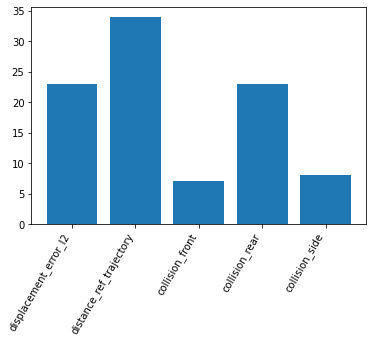

In [17]:
from src.validate.validator import CLEValidator
import matplotlib.pyplot as plt
import numpy as np

agg = CLEValidator(sim_outs)
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()